In [1]:
%matplotlib inline

import matplotlib 
import numpy as np
import pandas as pd
import os, sys, time, pickle, copy
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection    

from scipy import optimize

import cv2 

matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=10)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=True)
matplotlib.rc('xtick.major', pad=7)
matplotlib.rc('xtick', direction="in")
matplotlib.rc('ytick', direction="in")
matplotlib.rc('xtick', top = True)
matplotlib.rc('ytick', right =True )
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(12, 9))



Chapter 5. 이미지 형상 처리 및 분석 (Morphological Image Processing)
===

# 5.1. 허프 변환 및 거리 변환 (Hough & Distance Transform)

## Hough Transform (대부분 numpy 이용)

In [6]:
def calc_hough_line_ends(imgshape, r, th, delta=0.001):
    if r >= np.sqrt(imgshape[0]**2+imgshape[1]**2):
        p1, p2 =(None, None), (None, None)
    elif np.abs(th) < delta: 
        p1 ,p2 =(r,0), (r, imgshape[0])
    elif np.abs(th-np.pi) < delta:
        p1, p2 =(None, None), (None, None)
    elif np.abs(th-np.pi/2) < delta :
        p1, p2 = (0, r), (imgshape[1], r)
    elif np.abs(th+np.pi/2) < delta :
        p1, p2 =(None, None), (None, None)
    elif (th<0.) and (th >-np.pi/2) :
        p1, p2 = (r/np.cos(th), 0), (imgshape[1], (r-imgshape[1]*np.cos(th))/np.sin(th))
        if (r-imgshape[1]*np.cos(th))/np.sin(th) >= imgshape[0] :
           
            p2 = ((r-imgshape[0]*np.sin(th))/np.cos(th) , imgshape[0])
        
    elif (th>0.) and (th < np.pi/2) :
        p1, p2 =  (0, r/np.sin(th)), (r/np.cos(th), 0),

    elif (th<np.pi) and (th > np.pi/2) :
        p1, p2 = (0, r/np.sin(th)), ((r-imgshape[0]*np.sin(th))/np.cos(th), imgshape[0])
    
    else :
        p1, p2 =(None, None), (None, None)
    
    
    return (p1[1], p2[1]), (p1[0], p2[0])

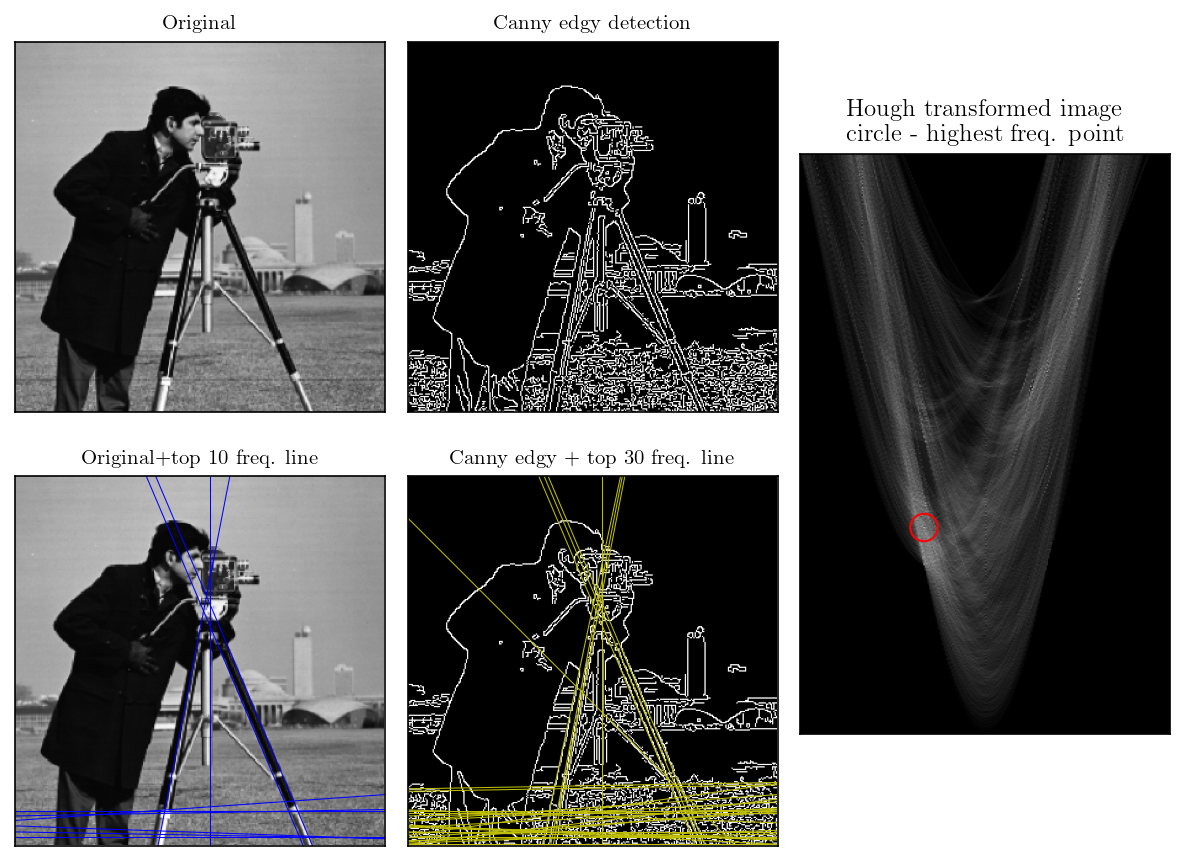

In [442]:
# Canny edge finding 을 제외하고는 python 과 numpy 만을 이용함.

img1=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)[20:-20:3,20:-20:3]
fig1 = plt.figure(figsize=(8,6), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5 = fig1.add_subplot(231), fig1.add_subplot(232), fig1.add_subplot(133),\
                        fig1.add_subplot(234), fig1.add_subplot(235)

ax1.imshow(img1, cmap='gray')
ax1.set_title("Original", size=10)
edge = cv2.Canny(img1, 50, 150)
ax2.imshow(edge, cmap='gray')
ax2.set_title("Canny edgy detection", size=10)

x, y = np.where(edge>0)

thetavec = np.arange(-90, 180.0, 1.)*np.pi/180;
r = np.floor(x[:,np.newaxis]@np.cos(thetavec)[np.newaxis, :] + y[:, np.newaxis]@np.sin(thetavec)[np.newaxis, :] ).astype(np.int64)
rmax = int(r.max()+1.0e-8)

acc=np.apply_along_axis(lambda a: np.histogram(a, bins=np.arange(-0.5, rmax+1))[0], 0, r)

ax3.imshow(acc, cmap='gray', vmin=0, vmax=200)
ax3.set_title("Hough transformed image \n circle - highest freq. point")

maxpoint = np.where(acc==acc.max())
rrmax, thmax = maxpoint[0][0], thetavec[maxpoint[1][0]]
draw_circle = plt.Circle((maxpoint[1][0], maxpoint[0][0]), 10 , color='r', fill=False)

ax3.add_patch(draw_circle)



ax4.imshow(img1, cmap='gray')


iid=np.unravel_index(np.argsort(-acc, axis=None), acc.shape)
for i in range(10):
    p1, p2 = calc_hough_line_ends(img1.shape, iid[0][i], thetavec[iid[1][i]])

    if (None not in p1) :
        ax4.plot(p1, p2, "b-", lw=0.5)

ax4.set_title("Original+top 10 freq. line", size=10)
ax4.set_xbound(-0.5, img1.shape[1]+0.5)
ax4.set_ybound(-0.5, img1.shape[0]+0.5)

ax5.imshow(edge, cmap='gray')

for i in range(30):
    p1, p2 = calc_hough_line_ends(img1.shape, iid[0][i], thetavec[iid[1][i]])

    if (None not in p1) :
        ax5.plot(p1, p2, "y-", lw=0.5)


ax5.set_title("Canny edgy + top 30 freq. line", size=10)
ax5.set_xbound(-0.5, img1.shape[1]+0.5)
ax5.set_ybound(-0.5, img1.shape[0]+0.5)

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig1.tight_layout()
plt.show()

## Hough Transform using OpenCv2

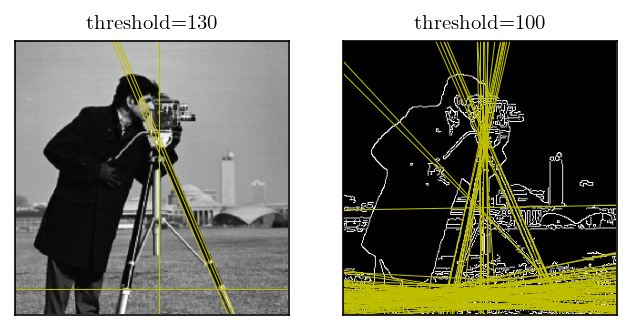

In [11]:
# opencv2 의 HoughLines 함수를 이용함.

img1=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)[20:-20:3,20:-20:3]
fig1 = plt.figure(figsize=(8,3), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2 =  fig1.add_subplot(131), fig1.add_subplot(132)

edges = cv2.Canny(img1,50,150,apertureSize = 3)
minLineLength = 50
maxLineGap = 10



ax1.imshow(img1, cmap='gray')

lines = cv2.HoughLines(edges,1,np.pi/180,130)
rho, theta = lines[:,:,0], lines[:,:, 1]
x0 = rho*np.cos(theta)
y0 = rho*np.sin(theta)

x1 = x0-1000*np.sin(theta)
y1 = y0+1000* np.cos(theta)
x2 = x0+1000*np.sin(theta)
y2 = y0-1000*np.cos(theta)

for i in range(len(x1)):
    ax1.plot((x1[i],x2[i]),(y1[i],y2[i]), 'y-', lw=0.5)

lines1 = cv2.HoughLines(edges,1,np.pi/180,100)

rho, theta = lines1[:,:,0], lines1[:,:, 1]
x0 = rho*np.cos(theta)
y0 = rho*np.sin(theta)

x1 = x0-1000*np.sin(theta)
y1 = y0+1000* np.cos(theta)
x2 = x0+1000*np.sin(theta)
y2 = y0-1000*np.cos(theta)

for i in range(len(x1)):
    ax2.plot((x1[i],x2[i]),(y1[i],y2[i]), 'y-', lw=0.5)
        
ax2.imshow(edges, cmap='gray')
ax1.set_title("threshold=130", size=10)
ax2.set_title("threshold=100", size=10)

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_xbound(-0.5, img1.shape[1]+0.5)
    ax.set_ybound(-0.5, img1.shape[0]+0.5)

plt.show()

# 5.2. 거리 변환 (Distance transform)

In [12]:
# image 의 맨하탄 거리 구하기.
# numpy 의 infinite number 는 float64 타입이므로 결과가 floating 값으로 나온다.

def manhathan_distance_2d_simple(img, Nsteps=3):
    mimg = np.zeros((img.shape[0]+2, img.shape[1]+2, 5))
    mimg.fill(np.infty)
    mimg[1:-1,1:-1,0]=img[:,:]

    for i in range(Nsteps):
        mimg[0:-2,1:-1,1]=mimg[1:-1,1:-1, 0]+1
        mimg[2:,1:-1,2]=mimg[1:-1,1:-1, 0]+1
        mimg[1:-1, 0:-2, 3]=mimg[1:-1,1:-1, 0]+1
        mimg[1:-1, 2:, 4]=mimg[1:-1,1:-1, 0]+1
        mimg[:,:, 0]=np.min(mimg, axis=2)
    return mimg[1:-1, 1:-1, 0]

def manhathan_distance_2d_mask(img, Nsteps=3, v1=3, v2=4):
    mimg = np.zeros((img.shape[0]+2, img.shape[1]+2, 9))
    mimg.fill(np.infty)
    mimg[1:-1,1:-1,0]=img[:,:]

    for i in range(Nsteps):
        mimg[0:-2,1:-1,1]=mimg[1:-1,1:-1, 0]+v1
        mimg[2:,1:-1,2]=mimg[1:-1,1:-1, 0]+v1
        mimg[1:-1, 0:-2, 3]=mimg[1:-1,1:-1, 0]+v1
        mimg[1:-1, 2:, 4]=mimg[1:-1,1:-1, 0]+v1
        mimg[0:-2, 0:-2, 5]=mimg[1:-1,1:-1, 0]+v2
        mimg[0:-2, 2:, 6]=mimg[1:-1,1:-1, 0]+v2
        mimg[2:, 2:, 7]=mimg[1:-1,1:-1, 0]+v2
        mimg[2:, 0:-2, 8]=mimg[1:-1,1:-1, 0]+v2
        mimg[:,:, 0]=np.min(mimg, axis=2)
    return mimg[1:-1, 1:-1, 0]/v1

def manhathan_distance_2d_mask2(img, Nsteps=3, v1=5, v2=7, v3=11):
    mimg = np.zeros((img.shape[0]+4, img.shape[1]+4, 17))
    mimg.fill(np.infty)
    mimg[2:-2,2:-2,0]=img[:,:]

    for i in range(Nsteps):
        mimg[1:-3,2:-2,1] = mimg[2:-2,2:-2,0] + v1
        mimg[3:-1,2:-2,2] = mimg[2:-2,2:-2,0] + v1
        mimg[2:-2, 1:-3, 3] = mimg[2:-2,2:-2,0] + v1
        mimg[2:-2, 3:-1, 4] = mimg[2:-2,2:-2,0] + v1
        mimg[1:-3, 1:-3, 5] = mimg[2:-2,2:-2,0] + v2
        mimg[1:-3, 3:-1, 6] = mimg[2:-2,2:-2,0] + v2
        mimg[3:-1, 1:-3, 7] = mimg[2:-2,2:-2,0] + v2
        mimg[3:-1, 3:-1, 8] = mimg[2:-2,2:-2,0] + v2
        mimg[0:-4, 3:-1, 9] = mimg[2:-2,2:-2,0] + v3
        mimg[0:-4, 1:-3, 10] = mimg[2:-2,2:-2,0] + v3
        mimg[4:, 3:-1, 11] = mimg[2:-2,2:-2,0] + v3
        mimg[4:, 1:-3, 12] = mimg[2:-2,2:-2,0] + v3
        mimg[3:-1, 0:-4, 13] = mimg[2:-2,2:-2,0] + v3
        mimg[3:-1, 4:, 14] = mimg[2:-2,2:-2,0] + v3
        mimg[1:-3, 0:-4, 15] = mimg[2:-2,2:-2,0] + v3
        mimg[1:-3, 4:, 16] = mimg[2:-2,2:-2,0] + v3
        
        
        
        mimg[:,:, 0]=np.min(mimg, axis=2)
        
    
    return mimg[2:-2, 2:-2, 0]/v1

# def skeletonization(img, Nstep = 3):
#     mimg = np.zeros((img.shape[0]+2, img.shape[1]+2, 5))
#     #mimg.fill(-np.infty)
#     mimg[1:-1,1:-1,0]=img[:,:]

#     for i in range(Nstep):
#         mimg[0:-2,1:-1,1]=mimg[1:-1,1:-1, 0]
#         mimg[2:,1:-1,2]=mimg[1:-1,1:-1, 0]
#         mimg[1:-1, 0:-2, 3]=mimg[1:-1,1:-1, 0]
#         mimg[1:-1, 2:, 4]=mimg[1:-1,1:-1, 0]
#         mimg[:,:, 0]=np.max(mimg[:,:,1:], axis=2)
#     return mimg[1:-1, 1:-1, 0]

In [13]:
mm = np.array([[np.infty]*6]*6)
mm[1,2]=mm[1,3]=mm[2,3]=mm[3,3]=mm[4,3]=mm[4,4]=0
manhathan_distance_2d_simple(mm, Nsteps=1)

array([[inf, inf,  1.,  1., inf, inf],
       [inf,  1.,  0.,  0.,  1., inf],
       [inf, inf,  1.,  0.,  1., inf],
       [inf, inf,  1.,  0.,  1., inf],
       [inf, inf,  1.,  0.,  0.,  1.],
       [inf, inf, inf,  1.,  1., inf]])

In [14]:
manhathan_distance_2d_mask(mm, Nsteps=3)

array([[2.33333333, 1.33333333, 1.        , 1.        , 1.33333333,
        2.33333333],
       [2.        , 1.        , 0.        , 0.        , 1.        ,
        2.        ],
       [2.33333333, 1.33333333, 1.        , 0.        , 1.        ,
        2.        ],
       [2.66666667, 2.        , 1.        , 0.        , 1.        ,
        1.33333333],
       [3.        , 2.        , 1.        , 0.        , 0.        ,
        1.        ],
       [3.33333333, 2.33333333, 1.33333333, 1.        , 1.        ,
        1.33333333]])

In [15]:
manhathan_distance_2d_mask2(mm, 1, 5, 7, 11)

array([[2.2, 1.4, 1. , 1. , 1.4, 2.2],
       [inf, 1. , 0. , 0. , 1. , 2.2],
       [2.2, 1.4, 1. , 0. , 1. , 2.2],
       [inf, 2.2, 1. , 0. , 1. , 1.4],
       [inf, 2.2, 1. , 0. , 0. , 1. ],
       [inf, 2.2, 1.4, 1. , 1. , 1.4]])

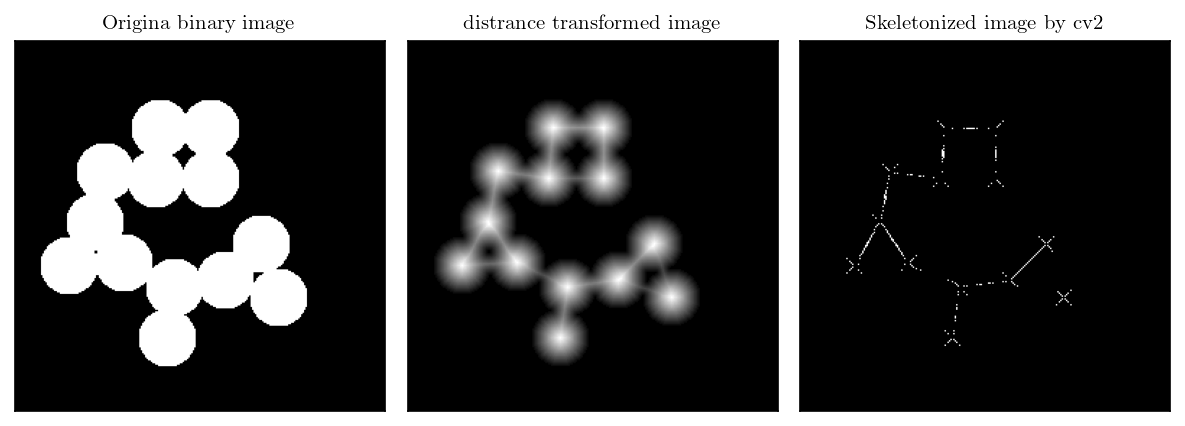

In [443]:
fig1 = plt.figure(figsize=(8,3), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3 =  fig1.add_subplot(131), fig1.add_subplot(132), fig1.add_subplot(133)

imgb = np.zeros((256, 256))
X, Y = np.meshgrid(np.arange(256), np.arange(256))

imgb[(X-100)**2+(Y-60)**2<20**2]=1
imgb[(X-135)**2+(Y-60)**2<20**2]=1
imgb[(X-135)**2+(Y-95)**2<20**2]=1
imgb[(X-97)**2+(Y-95)**2<20**2]=1
imgb[(X-62)**2+(Y-90)**2<20**2]=1
imgb[(X-55)**2+(Y-125)**2<20**2]=1
imgb[(X-37)**2+(Y-155)**2<20**2]=1
imgb[(X-75)**2+(Y-153)**2<20**2]=1
imgb[(X-110)**2+(Y-170)**2<20**2]=1
imgb[(X-105)**2+(Y-205)**2<20**2]=1
imgb[(X-145)**2+(Y-165)**2<20**2]=1
imgb[(X-170)**2+(Y-140)**2<20**2]=1
imgb[(X-182)**2+(Y-177)**2<20**2]=1

ax1.imshow(imgb, cmap='gray')
ax1.set_title("Origina binary image", size=10)
img0 = np.array(imgb, copy=True)
imt = np.array(img0, copy=True).astype(np.uint8)
img0[img0==1]=np.infty
img0[img0==0]=1


img1 = manhathan_distance_2d_mask2(img0, 10)
img2 = np.array(img1, copy=True)
img2[img2==np.infty]=1.
ax2.imshow(img2, cmap='gray')
ax2.set_title("distrance transformed image", size=10)

# img3 = img2.max()-img2
# #img3[img2==1.]=np.infty
# img4 = skeletonization(img3, 7)
# ax3.imshow(img4.max()-img4, cmap='gray')
imt=((img2-img2.min())/(img2.max()-img2.min())*255).astype(np.uint8)
skel = np.zeros(imt.shape,np.uint8)
size = np.size(imt)
ret,img = cv2.threshold(imt,125,255,0)
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
for i in range(10):
    eroded = cv2.erode(img,element)
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(img,temp)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()
 
    zeros = size - cv2.countNonZero(img)

ax3.imshow(skel, cmap='gray')
ax3.set_title("Skeletonized image by cv2", size=10)

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig1.tight_layout()
plt.show()

# 5.3. 이미지 형태 바꾸기 (Morphological Processing)

In [437]:
def binaryimage_expansion(img, ker):
    size = ker.shape
    edge = ((size[0]-1)>>1, (size[1]-1)>>1)
    pkind = np.where(ker>0)
    
    imt = np.zeros((img.shape[0]+2*edge[0], img.shape[1]+2*edge[1], pkind[0].shape[0]))
    #imt[edge[0]:-edge[0],edge[1]:-edge[1],0]=img[:,:]

    for ind, pp in enumerate(zip(pkind[0], pkind[1])):
        p0, p1 = pp
        imt[(2*edge[0]-p0):(2*edge[0]-p0+img.shape[0]),(2*edge[1]-p1):(2*edge[1]-p1+img.shape[1]),ind] \
                    = img[:,:]
    
    result=np.max(imt, axis=2)
    return result[edge[0]:-edge[0],edge[1]:-edge[1]]

def binaryimage_errosion(img, ker):
    size = ker.shape
    edge = ((size[0]-1)>>1, (size[1]-1)>>1)
    pkind = np.where(ker>0)
    
    imt = np.zeros((img.shape[0]+2*edge[0], img.shape[1]+2*edge[1], pkind[0].shape[0]))
    #imt[edge[0]:-edge[0],edge[1]:-edge[1],0]=img[:,:]

    for ind, pp in enumerate(zip(pkind[0], pkind[1])):
        p0, p1 = pp
        imt[(2*edge[0]-p0):(2*edge[0]-p0+img.shape[0]),(2*edge[1]-p1):(2*edge[1]-p1+img.shape[1]),ind] \
                    = img[:,:]
    
    result=np.min(imt, axis=2)
    return result[edge[0]:-edge[0],edge[1]:-edge[1]]

In [18]:
## 권석준 교수 그림 5.17 예제 확인
ker = np.array([[1,0,1],[0,1,0],[1,0,1]])
iig = np.array([[0,0,0,0,0],[0,1,1,0,0],[0,1,1,0,0],[0,1,1,0,0],[0,1,1,1,0],[0,0,1,1,0],[0,0,0,0,0]])
binaryimage_expansion(iig, ker)

array([[1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.]])

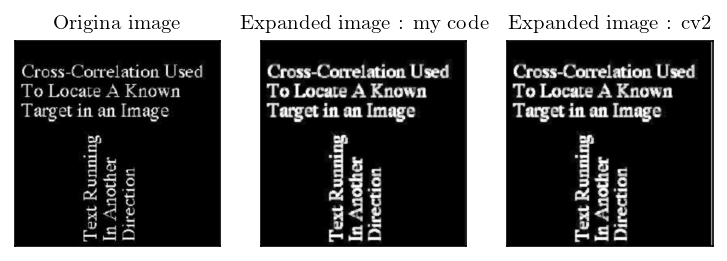

In [438]:
fig1 = plt.figure(figsize=(6,3), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3 =  fig1.add_subplot(131), fig1.add_subplot(132), fig1.add_subplot(133)

ker = np.array([[1,0,1],[0,1,0],[1,0,1]])

img1=cv2.cvtColor(cv2.imread("./img_text_01.png"), cv2.COLOR_BGR2GRAY)
ax1.imshow(img1, cmap='gray')
ax1.set_title("Origina image", size=10)

img2 = binaryimage_expansion(img1, ker)
ax2.imshow(img2, cmap='gray')
ax2.set_title("Expanded image : my code", size=10)

img3 = cv2.dilate(img1, ker.astype(np.uint8), iterations=1)
ax3.imshow(img3, cmap="gray")
ax3.set_title("Expanded image : cv2", size=10)
for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

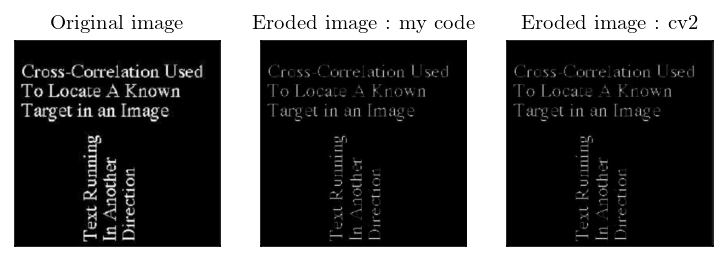

In [439]:
fig1 = plt.figure(figsize=(6,3), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3 =  fig1.add_subplot(131), fig1.add_subplot(132), fig1.add_subplot(133)

ker = np.array([[1,0,1],[0,1,0],[1,0,1]])

img1=cv2.cvtColor(cv2.imread("./img_text_01.png"), cv2.COLOR_BGR2GRAY)
ax1.imshow(img1, cmap='gray')
ax1.set_title("Original image", size=10)

img2 = binaryimage_errosion(img1, ker)
ax2.imshow(img2, cmap='gray')
ax2.set_title("Eroded image : my code", size=10)

img3 = cv2.erode(img1, ker.astype(np.uint8), iterations=1)
ax3.imshow(img3, cmap='gray')
ax3.set_title("Eroded image : cv2", size=10)

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

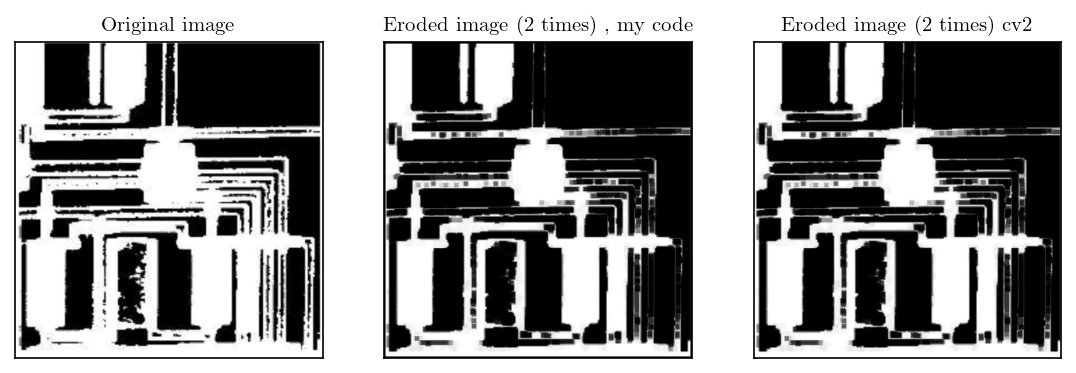

In [440]:
fig1 = plt.figure(figsize=(9,5), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3 =  fig1.add_subplot(131), fig1.add_subplot(132), fig1.add_subplot(133)

ker = np.array([[1,0,1],[0,1,0],[1,0,1]])

img1=cv2.cvtColor(cv2.imread("./img_erossion_01.png"), cv2.COLOR_BGR2GRAY)
ax1.imshow(img1, cmap='gray')
ax1.set_title("Original image", size=10)

img2 = np.array(img1, copy=True)
for i in range(2):
    img2 = binaryimage_errosion(img2, ker)

ax2.imshow(img2, cmap='gray')
ax2.set_title("Eroded image (2 times) , my code", size=10)

img3 = cv2.erode(img1, ker.astype(np.uint8), iterations=2)
ax3.imshow(img3, cmap='gray')
ax3.set_title("Eroded image (2 times) cv2 ", size=10)

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

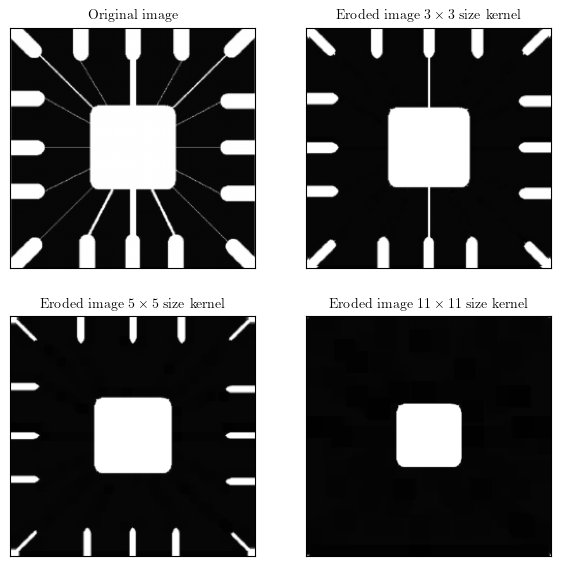

In [441]:
fig1 = plt.figure(figsize=(7,7), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4 = fig1.add_subplot(221), fig1.add_subplot(222), fig1.add_subplot(223), \
                    fig1.add_subplot(224)

ker1 = np.array([[1,0,1],[0,1,0],[1,0,1]])

ker2 = np.ones((5,5), np.uint8)

ker3 = np.ones((11,11), np.uint8)
img1=cv2.cvtColor(cv2.imread("./img_erossion_02.png"), cv2.COLOR_BGR2GRAY)
ax1.imshow(img1, cmap='gray')
ax1.set_title("Original image", size=10)

img2 = cv2.erode(img1, ker1.astype(np.uint8), iterations=2)

ax2.imshow(img2, cmap='gray')
ax2.set_title("Eroded image $3\\times3$ size kernel", size=10)

img3 = cv2.erode(img1, ker2, iterations=2)
ax3.imshow(img3, cmap='gray')
ax3.set_title("Eroded image $5\\times5$ size kernel", size=10)

img4 = cv2.erode(img1, ker3, iterations=2)
ax4.imshow(img4, cmap='gray')
ax4.set_title("Eroded image $11\\times 11$ size kernel", size=10)

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

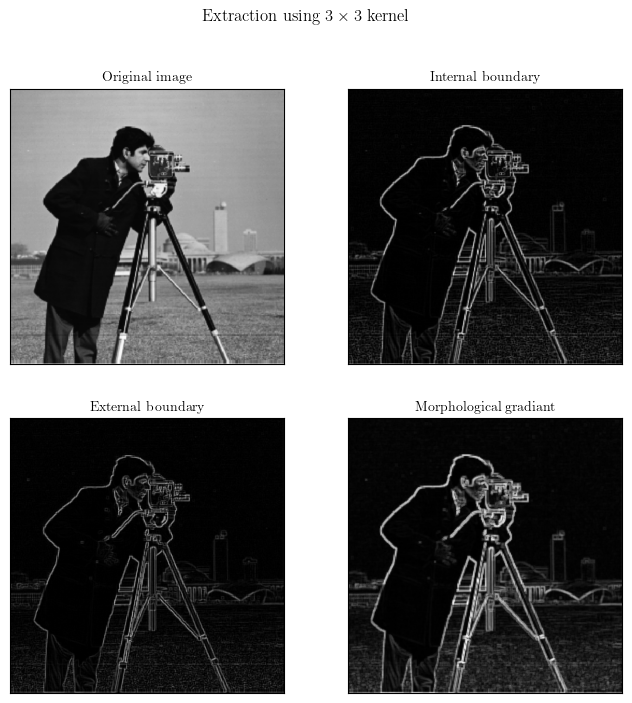

In [23]:
img1=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)[::2,::2]
fig1 = plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4=  fig1.add_subplot(221), fig1.add_subplot(222),fig1.add_subplot(223),\
                    fig1.add_subplot(224)

ax1.imshow(img1, cmap='gray')
ker1 = np.array([[1,0,1],[0,1,0],[1,0,1]]).astype(np.uint8)
ax1.set_title("Original image", size=10)

dilated_img = cv2.dilate(img1, ker1, iterations=1)
eroded_img = cv2.erode(img1, ker1, iterations=2)

img_intb = img1-eroded_img
ax2.imshow(img_intb, cmap="gray")
ax2.set_title("Internal boundary", size=10)

img_extb = dilated_img - img1
ax3.imshow(img_extb, cmap="gray")
ax3.set_title("External boundary", size=10)

img_grad = dilated_img - eroded_img
ax4.imshow(img_grad, cmap="gray")
ax4.set_title("Morphological gradiant", size=10)

fig1.suptitle("Extraction using $3\\times 3$ kernel")
for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

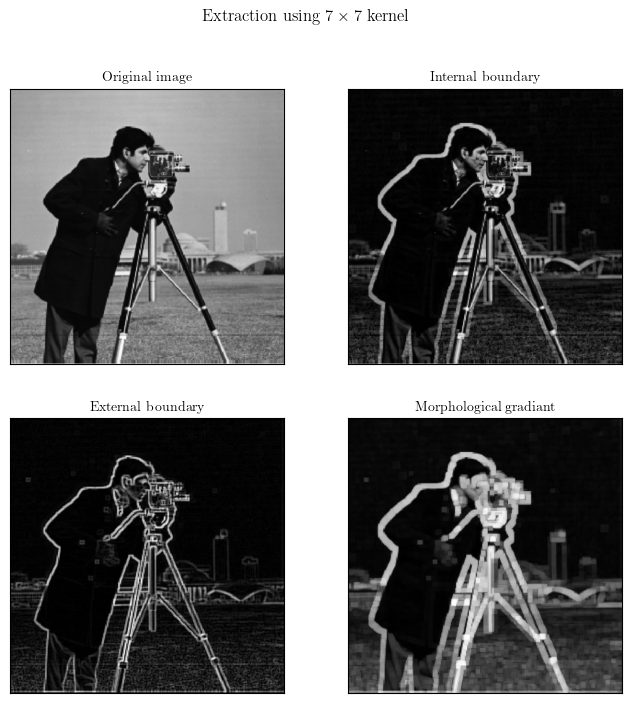

In [24]:
img1=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)[::2,::2]
fig1 = plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4=  fig1.add_subplot(221), fig1.add_subplot(222),fig1.add_subplot(223),\
                    fig1.add_subplot(224)

ax1.imshow(img1, cmap='gray')
ker1 = np.ones((7,7),np.uint8)
ax1.set_title("Original image", size=10)

dilated_img = cv2.dilate(img1, ker1, iterations=1)
eroded_img = cv2.erode(img1, ker1, iterations=2)

img_intb = img1-eroded_img
ax2.imshow(img_intb, cmap="gray")
ax2.set_title("Internal boundary", size=10)

img_extb = dilated_img - img1
ax3.imshow(img_extb, cmap="gray")
ax3.set_title("External boundary", size=10)

img_grad = dilated_img - eroded_img
ax4.imshow(img_grad, cmap="gray")
ax4.set_title("Morphological gradiant", size=10)

fig1.suptitle("Extraction using $7\\times 7$ kernel")
for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Image smoothing by image opening

In [77]:
def matlab_disk_kernel(radius=5):
    """
    equivalent to matlab strel('disk',r)
    """
    size = radius*2-1
    kernel = np.zeros((size, size)).astype(np.uint8)
    X, Y = np.meshgrid(np.arange(size), np.arange(size))
    kernel[((X-radius+1)**2+(Y-radius+1)**2) < radius**2] = 1
    return kernel

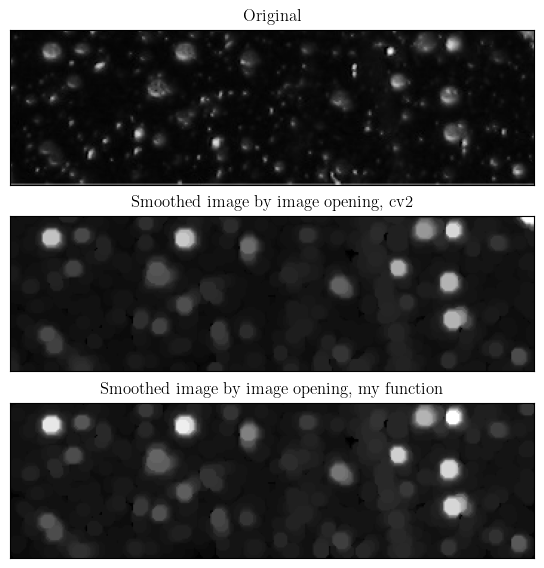

In [78]:
img1=cv2.cvtColor(cv2.imread("./img_ordfilt_01.jpg"), cv2.COLOR_BGR2GRAY)[::5, ::5]
fig1 = plt.figure(figsize=(7,7), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3 =  fig1.add_subplot(311), fig1.add_subplot(312), fig1.add_subplot(313)

ax1.imshow(img1, cmap='gray')
ax1.set_title("Original")
ker1 = np.array([[1,0,1],[0,1,0],[1,0,1]]).astype(np.uint8)

## kernel equivalent to matlab strel('disk',5)
ker5 = matlab_disk_kernel(5)

## cv2 function equivalent to matlab's imopen
img2 = cv2.morphologyEx(img1, cv2.MORPH_OPEN, ker5)

ax2.imshow(img2, cmap='gray')
ax2.set_title("Smoothed image by image opening, cv2")


## using my function
eroded_img = binaryimage_errosion(img1, ker5)
dilated_img =binaryimage_expansion(eroded_img, ker5)
ax3.imshow(dilated_img, cmap="gray")
ax3.set_title("Smoothed image by image opening, my function")


for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

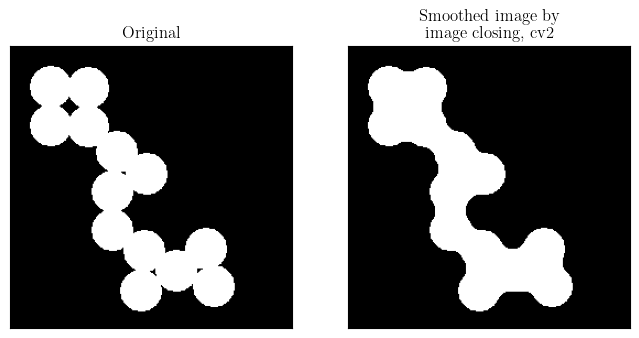

In [88]:
img1=cv2.cvtColor(cv2.imread("./cjs_circles.png"), cv2.COLOR_BGR2GRAY)
fig1 = plt.figure(figsize=(8,5), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2 =  fig1.add_subplot(121), fig1.add_subplot(122)

ax1.imshow(img1, cmap='gray')
ax1.set_title("Original")

kernel = matlab_disk_kernel(11)
img2 = cv2.morphologyEx(img1, cv2.MORPH_CLOSE, kernel)
ax2.imshow(img2, cmap='gray')
ax2.set_title("Smoothed image by\nimage closing, cv2")
## using my function

# dilated_img =binaryimage_expansion(img1, kernel)
# eroded_img = binaryimage_errosion(dilated_img, kernel)
# ax3.imshow(eroded_img, cmap="gray")
# ax3.set_title("Smoothed image by \nimage closing, my function")

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## 형상 필터링을 이용한 노이즈 처리

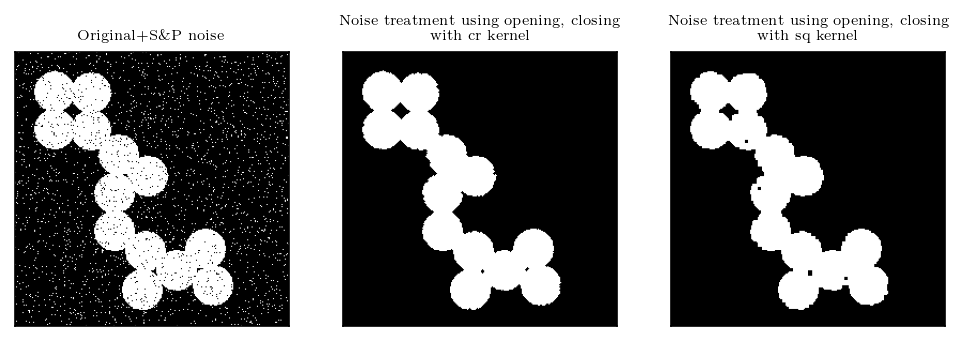

In [444]:
img1=cv2.cvtColor(cv2.imread("./cjs_circles.png"), cv2.COLOR_BGR2GRAY)
fig1 = plt.figure(figsize=(8,3), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3 =  fig1.add_subplot(131), fig1.add_subplot(132), fig1.add_subplot(133)

# S&P noise 
N=5000
nx = np.random.randint(0, img1.shape[0], N)
ny = np.random.randint(0, img2.shape[1], N)

img1[nx[::2], ny[::2]]=0
img1[nx[1::2], ny[1::2]]=255
# cr = [0 1 0; 1 1 1; 0 1 0]; % kernel
# sq = ones(3,3);
ker_cr = np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]], np.uint8)
ker_sq = np.ones((3,3), np.uint8)

ax1.imshow(img1, cmap='gray')
ax1.set_title("Original+S\&P noise", size=7)

img2 = cv2.morphologyEx(cv2.morphologyEx(img1, cv2.MORPH_OPEN, ker_cr), cv2.MORPH_CLOSE, ker_cr)
ax2.imshow(img2, cmap='gray')
ax2.set_title("Noise treatment using opening, closing\nwith cr kernel", size=7)

img3 = cv2.morphologyEx(cv2.morphologyEx(img1, cv2.MORPH_OPEN, ker_sq), cv2.MORPH_CLOSE, ker_sq)
ax3.imshow(img3, cmap='gray')
ax3.set_title("Noise treatment using opening, closing\nwith sq kernel", size=7)

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()



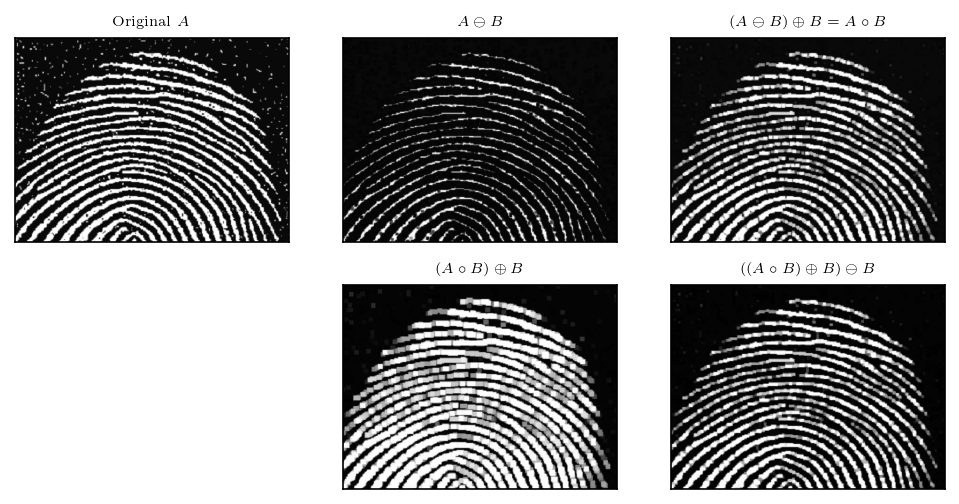

In [208]:
img1=cv2.cvtColor(cv2.imread("./fingerprint.jpg"), cv2.COLOR_BGR2GRAY)
fig1 = plt.figure(figsize=(8,4), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5 =  fig1.add_subplot(231), fig1.add_subplot(232), fig1.add_subplot(233),\
                    fig1.add_subplot(235), fig1.add_subplot(236)


ax1.imshow(img1, cmap='gray')
ax1.set_title("Original $A$", size=7)

kernel = np.ones((3,3), np.uint8)
img2 = cv2.erode(img1, kernel, iterations=2)
ax2.imshow(img2, cmap='gray')
ax2.set_title("$A \\ominus B$", size=7)

img3 = cv2.dilate(img2, kernel, iterations=2)
ax3.imshow(img3, cmap='gray')
ax3.set_title("$(A \\ominus B) \\oplus B = A \\circ B$", size=7)

img4 = cv2.dilate(img3, kernel, iterations=2)
ax4.imshow(img4, cmap='gray')
ax4.set_title("$(A \\circ B) \\oplus B$", size=7)

img5 = cv2.erode(img4, kernel, iterations=2)
ax5.imshow(img5, cmap='gray')
ax5.set_title("$((A \\circ B) \\oplus B) \\ominus B$", size=7)



for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()



## Region Filling

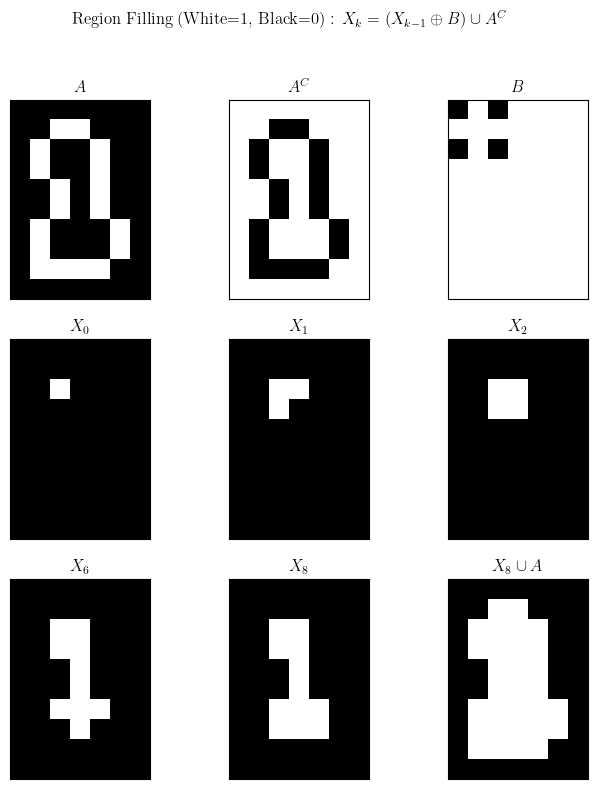

In [445]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
fig.set_size_inches((8,9))
fig.set_dpi(100)

imgA = np.array([[0,0,0,0,0,0,0],[0,0,1,1,0,0,0],[0,1,0,0,1,0,0], [0,1,0,0,1,0,0],\
                 [0,0,1,0,1,0,0],[0,0,1,0,1,0,0],[0,1,0,0,0,1,0], [0,1,0,0,0,1,0],\
                 [0,1,1,1,1,0,0],[0,0,0,0,0,0,0]])

Ac=1-imgA
kerB = np.array([[0,1,0],[1,1,1],[0,1,0]], np.uint8)
axs[0,0].imshow(imgA, cmap='gray')
axs[0,0].set_title("$A$")

axs[0,1].imshow(Ac, cmap='gray')
axs[0,1].set_title("$A^C$")

axs[0,2].imshow(kerB, cmap='gray')
axs[0,2].set_title("$B$")

X0 = np.zeros(imgA.shape)
X0[2,2]=1
axs[1,0].imshow(X0, cmap='gray')
axs[1,0].set_title("$X_0$")

X1=cv2.dilate(X0, kerB, iterations=1)*Ac
axs[1,1].imshow(X1, cmap='gray')
axs[1,1].set_title("$X_1$")

X2=cv2.dilate(X1, kerB, iterations=1)*Ac
axs[1,2].imshow(X2, cmap='gray')
axs[1,2].set_title("$X_2$")

X3=cv2.dilate(X2, kerB, iterations=1)*Ac
X4=cv2.dilate(X3, kerB, iterations=1)*Ac
X5=cv2.dilate(X4, kerB, iterations=1)*Ac
X6=cv2.dilate(X5, kerB, iterations=1)*Ac
X7=cv2.dilate(X6, kerB, iterations=1)*Ac
X8=cv2.dilate(X7, kerB, iterations=1)*Ac


axs[2,0].imshow(X6, cmap='gray')
axs[2,0].set_title("$X_6$")

axs[2,1].imshow(X8, cmap='gray')
axs[2,1].set_title("$X_8$")

AX8=((X8+imgA)>0).astype(np.int8)

axs[2,2].imshow(AX8, cmap='gray')
axs[2,2].set_title("$X_8 \cup A$")

fig.suptitle("Region Filling (White=1, Black=0) : $X_k = (X_{k-1} \\oplus B) \\cup A^C$")
for ax in fig.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig1.tight_layout()
plt.show()



## Region Connection

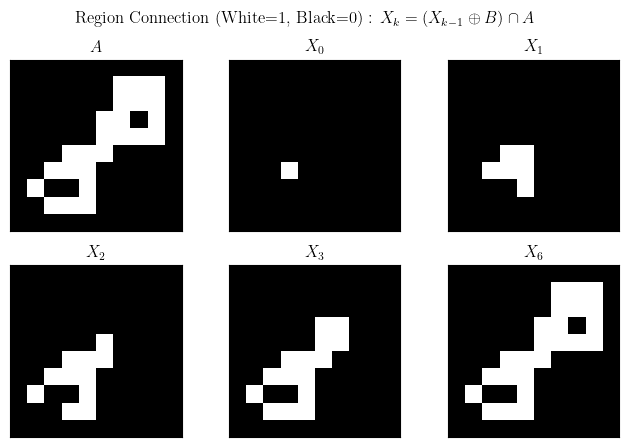

In [252]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
fig.set_size_inches((8,5))
fig.set_dpi(100)

A = np.array([[0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,1,1,1,0], [0,0,0,0,0,0,1,1,1,0],\
                 [0,0,0,0,0,1,1,0,1,0], [0,0,0,0,0,1,1,1,1,0], [0,0,0,1,1,1,0,0,0,0],\
                 [0,0,1,1,1,0,0,0,0,0], [0,1,0,0,1,0,0,0,0,0], [0,0,1,1,1,0,0,0,0,0],\
                 [0,0,0,0,0,0,0,0,0,0]], np.int16)


kerB = np.ones((3,3), np.uint8)


X0 = np.zeros(A.shape, np.int16)
X0[6,3]=1
axs[0,0].imshow(A, cmap='gray')
axs[0,0].set_title("$A$")

axs[0,1].imshow(X0, cmap='gray')
axs[0,1].set_title("$X_0$")




X1=(cv2.dilate(X0, kerB, iterations=1)*A)
axs[0,2].imshow(X1, cmap='gray')
axs[0,2].set_title("$X_1$")

X2=cv2.dilate(X1, kerB, iterations=1)*A
X3=cv2.dilate(X2, kerB, iterations=1)*A
X4=cv2.dilate(X3, kerB, iterations=1)*A
X5=cv2.dilate(X4, kerB, iterations=1)*A
X6=cv2.dilate(X5, kerB, iterations=1)*A


axs[1,0].imshow(X2, cmap='gray')
axs[1,0].set_title("$X_2$")

axs[1,1].imshow(X3, cmap='gray')
axs[1,1].set_title("$X_3$")

axs[1,2].imshow(X6, cmap='gray')
axs[1,2].set_title("$X_6$")

fig.suptitle("Region Connection (White=1, Black=0) : $X_k = (X_{k-1} \\oplus B) \\cap A$")
for ax in fig.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

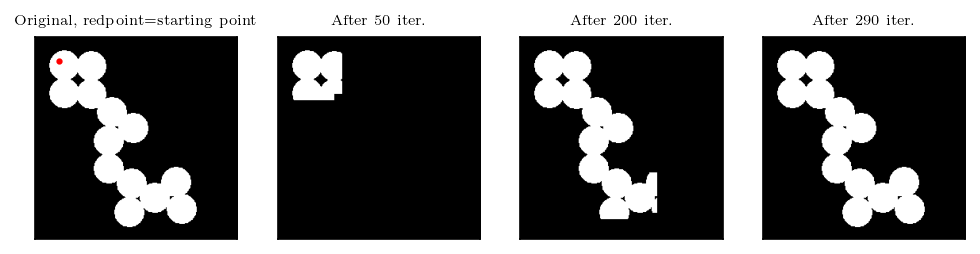

In [279]:
img1=cv2.cvtColor(cv2.imread("./cjs_circles.png"), cv2.COLOR_BGR2GRAY)
fig1 = plt.figure(figsize=(8,3), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4 =  fig1.add_subplot(141), fig1.add_subplot(142), fig1.add_subplot(143), fig1.add_subplot(144)

img1=(img1>150).astype(np.int16)
kerB = np.ones((3,3), np.uint8)

ax1.imshow(img1, cmap='gray')
ax1.plot((30,), (30, ), "ro", ms=2)
ax1.set_title("Original, redpoint=starting point", size=7)
XX = np.zeros(img1.shape, dtype=np.int16)
XX[30, 30]=1

for i in range(50):
    XX=cv2.dilate(XX, kerB, iterations=1)*img1
ax2.imshow(XX, cmap='gray')
ax2.set_title("After 50 iter.", size=7)

for i in range(150):
    XX=cv2.dilate(XX, kerB, iterations=1)*img1
ax3.imshow(XX, cmap='gray')
ax3.set_title("After 200 iter.", size=7)

for i in range(40):
    XX=cv2.dilate(XX, kerB, iterations=1)*img1
ax4.imshow(XX, cmap='gray')
ax4.set_title("After 290 iter.", size=7)



for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


## Image skeletonization


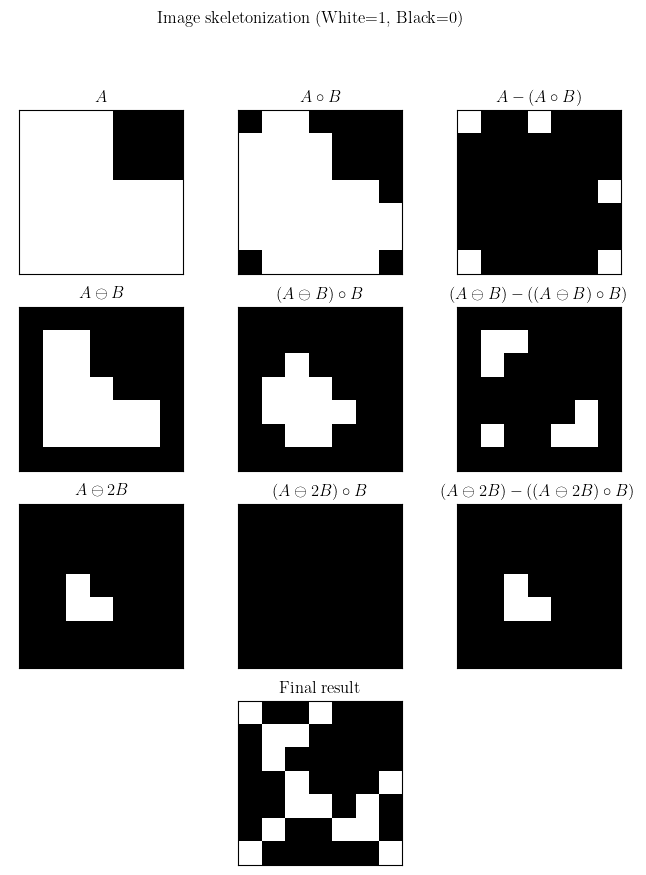

In [385]:
fig, axs = plt.subplots(4, 3)
fig.set_size_inches((8,10))
fig.set_dpi(100)
A0 = np.ones((7,7))
A0[0:3,4:]=0
A=np.zeros((9,9))
A[1:-1,1:-1]=A0


kerB = np.ones((3,3), np.uint8)
#kerB = np.array([[0,1,0],[1,1,1],[0,1,0]], np.uint8)
ker_cr = np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]], np.uint8)
ker_sq = np.ones((3,3), np.uint8)


axs[0,0].imshow(A[1:-1,1:-1], cmap='gray')
axs[0,0].set_title("$A$")

X0=cv2.morphologyEx(A, cv2.MORPH_OPEN, ker_cr, iterations=1)
axs[0,1].imshow(X0[1:-1,1:-1], cmap='gray')
axs[0,1].set_title("$A \\circ B$")

X1=A-X0
axs[0,2].imshow(X1[1:-1,1:-1], cmap='gray')
axs[0,2].set_title("$A-(A \\circ B)$")


X2=cv2.erode(A, ker_cr, iterations=1)

axs[1,0].imshow(X2[1:-1,1:-1], cmap='gray')
axs[1,0].set_title("$A \\ominus B$")

X3=cv2.morphologyEx(X2, cv2.MORPH_OPEN, ker_cr, iterations=1)
axs[1,1].imshow(X3[1:-1,1:-1], cmap='gray')
axs[1,1].set_title("$(A\\ominus B) \\circ B$")

X1f=(X2-X3)
axs[1,2].imshow(X1f[1:-1,1:-1], cmap='gray')
axs[1,2].set_title("$(A \\ominus B) - ((A\\ominus B) \\circ B)$")


X4 = cv2.erode(A, ker_cr, iterations=2)
axs[2,0].imshow(X4[1:-1,1:-1], cmap='gray')
axs[2,0].set_title("$A \\ominus 2B$")

X5 = cv2.morphologyEx(X4, cv2.MORPH_OPEN, ker_cr, iterations=1)
axs[2,1].imshow(X5[1:-1,1:-1], cmap='gray')
axs[2,1].set_title("$(A\\ominus 2B) \\circ B$")

X6 = X4-X5
axs[2,2].imshow(X6[1:-1,1:-1], cmap='gray')
axs[2,2].set_title("$(A \\ominus 2B)-((A\\ominus 2B) \\circ B)$")

Xf = ((X1+X1f+X6)>0).astype(np.int16)
axs[3,1].imshow(Xf[1:-1,1:-1], cmap='gray')
axs[3,1].set_title("Final result")

axs[3,0].axis('off')

axs[3,2].axis('off')

fig.suptitle("Image skeletonization (White=1, Black=0)")
for ax in fig.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

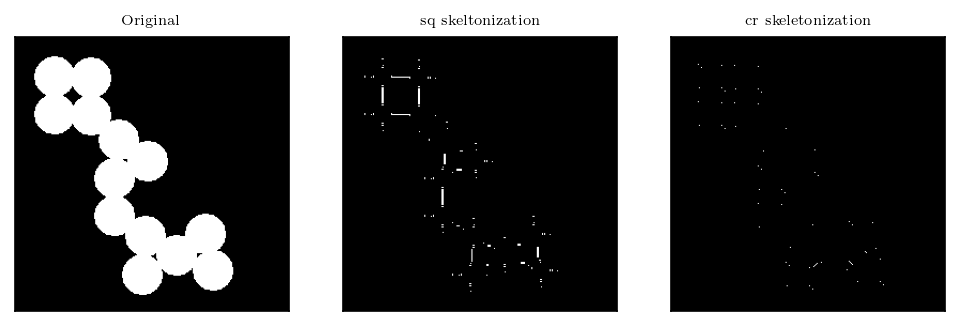

In [435]:
def sekeletonization(img, ker, th=0, iter=10):
    A0 = (img>0).astype(np.int32)
    A=np.zeros((img.shape[0]+2, img.shape[1]+2), np.int16)
    A[1:-1, 1:-1]=A0
    
    
    X0=cv2.morphologyEx(A, cv2.MORPH_OPEN, ker, iterations=1)
    XX=A-X0
    for i in range(1, 10):
        X2=cv2.erode(A, ker, iterations=i)
        X3=cv2.morphologyEx(X2, cv2.MORPH_OPEN, ker, iterations=1)
        XX += (X2-X3)
        
    return XX[1:-1, 1:-1]

ker_cr = np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]], np.uint8)
ker_sq = np.ones((3,3), np.uint8)


img1=cv2.cvtColor(cv2.imread("./circles.png"), cv2.COLOR_BGR2GRAY)

fig1 = plt.figure(figsize=(8,3), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3=  fig1.add_subplot(131), fig1.add_subplot(132), fig1.add_subplot(133)

kerB = np.ones((3,3), np.uint8)

ax1.imshow(img1, cmap='gray')
ax1.set_title("Original", size=7)

ax2.imshow(sekeletonization(img1, ker_sq, 0, 50), cmap='gray')
ax2.set_title("sq skeltonization", size=7)

ax3.imshow(sekeletonization(img1, ker_cr, 0, 50), cmap='gray')
ax3.set_title("cr skeletonization", size=7)


for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

